In [59]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time as time
from kohonen import *
from helpers import *
%load_ext autoreload
%autoreload 2
    
# load in data and labels    
data_pure = np.array(np.loadtxt('data/data.txt'))
labels = np.loadtxt('data/labels.txt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


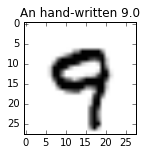

In [11]:
data_matrix = rewritedata(data)
i = 36
visualize(data_matrix[i,:,:],labels[i])

In [57]:
#useful data
dim = 28*28
data_range = 255.0
    
# load in data and labels    
#data = np.array(np.loadtxt('data/data.txt'))
#labels = np.loadtxt('data/labels.txt')

# select 4 digits    
name = 'Andre Cibils' # REPLACE BY YOUR OWN NAME
targetdigits = name2digits(name) # assign the four digits that should be used
print(targetdigits) # output the digits that were selected
# this selects all data vectors that corresponds to one of the four digits
data = data_pure[np.logical_or.reduce([labels==x for x in targetdigits]),:]
    
dy, dx = data.shape
    
#set the size of the Kohonen map. In this case it will be 6 X 6
size_k = 6
    
#set the width of the neighborhood via the width of the gaussian that
#describes it
sigma = 1.1

#set the learning rate
eta = 0.8 # HERE YOU HAVE TO SET YOUR OWN LEARNING RATE
    
#set the maximal iteration count
tmax = 2000 # this might or might not work; use your own convergence criterion

[0 5 7 9]


C:\Users\André\Documents\GitHub\NeuralNetwork_proj1\src\kohonen.py:144: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.sort(x[t,:])


In [19]:
#return eucl distance between the data and a center
def distance(vec1,vec2):
    assert np.shape(vec1)==np.shape(vec2)
    #print("   Distance between",vec1,"and",vec2)
    term1 = np.power(vec1-vec2,2)
    #print("      term1 :",term1)
    term2 = np.sqrt(np.sum(term1,axis=1))
    #print("      term2 :",term2)
    return term2

def assign_cluster(centers, datas):
    #initialization
    cluster_assignment = np.zeros(np.shape(datas)[0]) - 1
    current_c = np.tile(centers[0], (np.shape(datas)[0],1))
    eucl_distance = distance(current_c,datas)
    min_distance = np.copy(eucl_distance)
    #find cluster for each entry in datas
    for i in range(0,np.shape(centers)[0]):
        #print("Center is : ",centers[i], "iteration : ",i)
        current_c = np.tile(centers[i], (np.shape(datas)[0],1))
        eucl_distance = distance(current_c,datas)
        #print("   MD :",min_distance)
        #print("   ED :",eucl_distance)
        bool_distance = eucl_distance <= min_distance
        #print("   BD :",bool_distance)
        min_distance = eucl_distance*(bool_distance) + min_distance*(1 - bool_distance)
        #print("   MD :",min_distance)        
        cluster_assignment = cluster_assignment*(1 - bool_distance) + i*bool_distance
        #print("   CA :",cluster_assignment)
    return cluster_assignment

def reconstruction_error(centers,datas):
    #E = SUM{k}(SUM{u in C_k}((Wk - Xu)^2) by the course
    #E is mean error of quantization
    #Show that error decrease to prove convergence
    #Th. After conv, each proto is at the center of his data cloud
    E = 0
    cluster_assignment = assign_cluster(centers,datas)
    #print("Assignement is :",cluster_assignment)
    for i in range(0, np.shape(centers)[0]):
        #print("Center is : ",centers[i], "iteration : ",i)
        C_k = cluster_assignment == i #bool_tab to see if Xu is in C_k
        #print("   C_k :",C_k)
        current_c = np.tile(centers[i], (np.shape(datas)[0],1))
        C_ks = np.tile(C_k,(np.shape(datas)[1],1)).T
        values = datas * C_ks + current_c * (1 - C_ks) #if Xu is in C_k, Xu = data, else Xu = centers so Wk-Xu = 0
        #print("   values :",values)
        #print("   curren_c :",current_c)
        d = distance(current_c,values) #compute SUM{u in C_k}((Wk - Xu)^2) and add it to current E
        #print("   d :",d)
        E = E + sum(d)
        #print("   E :",E)
    return E

In [20]:
#Test cell for distance, ass cluster & rec error :)

print("----------TEST DISTANCE")
vec1 = [[3,4,8,0,0],[1,1,1,1,1]]
vec2 = [1,4,8,1,1]
v2 = np.tile(vec2,(2,1))
#print(distance(vec1,v2))

print("----------TEST ASSIGN")

datas = [[1,1,3],[8,2,7],[1,3,1],[6,3,3],[1,2,2],[4,8,3],[1,8,1],[7,3,4],[5,4,2]]
centers = [[2,3,1],[8,8,4], [8,2,6], [3,4,7]]
print(datas)
print(centers)
#ass = assign_cluster(centers,datas)
#print(ass)
print("----------TEST ERROR")

datas = [[1,1],[2,2],[4,0]]
centers = [[1,1],[0,1],[2,3]]
print(reconstruction_error(centers,datas))

----------TEST DISTANCE
----------TEST ASSIGN
[[1, 1, 3], [8, 2, 7], [1, 3, 1], [6, 3, 3], [1, 2, 2], [4, 8, 3], [1, 8, 1], [7, 3, 4], [5, 4, 2]]
[[2, 3, 1], [8, 8, 4], [8, 2, 6], [3, 4, 7]]
----------TEST ERROR
4.16227766017


In [21]:
def kohonen(data,labels,learning_rates):
    """Example for using create_data, plot_data and som_step.
    """
    plb.close('all')
    
    losses = []
    for a in range(0,np.shape(learning_rates)[0]):    
        #initialise the centers randomly
        centers = np.random.rand(size_k**2, dim) * data_range
        #build a neighborhood matrix
        neighbor = np.arange(size_k**2).reshape((size_k, size_k))
        #set the random order in which the datapoints should be presented
        i_random = np.arange(tmax) % dy
        np.random.shuffle(i_random)
        plb.figure
        print("Iteration number is",a,". Learning rate for this iteration is :",learning_rates[a])
        for t, i in enumerate(i_random):
            centers = som_step(centers, data[i,:],neighbor,learning_rates[a],sigma)
            loss = reconstruction_error(centers,data)
            losses.append(loss)
            if(t<=10 and t>20):
            #visualization:
                plb.figure(i)
                
                for i in range(0,size_k**2):
                    plb.subplot(size_k,size_k,i+1)
                    plb.imshow(np.reshape(centers[i,:], [28, 28]),cmap='Greys',interpolation='bilinear')
                    plb.axis('off')
                plb.annotate("plot_num:"+str(t)+";"+str(learning_rates[a]),xy=(0,27))
                plb.annotate("E="+str(loss), xy = (0,0))
                plb.savefig("plots/plot_E"+"_eta"+str(learning_rates[a])+"_num"+str(t)+".png")
                plb.close(i)
    # leave the window open at the end of the loop
        plb.show()
        plb.draw()
               
    return losses

learning_rates = [0.2,0.5,0.8]
losses = kohonen(data,labels,learning_rates)

Iteration number is 0 . Learning rate for this iteration is : 0.2
Iteration number is 1 . Learning rate for this iteration is : 0.5


Iteration number is 2 . Learning rate for this iteration is : 0.8


Iteration number is 0 . Will iterate 0.8 time on the data set here.
(1,)


C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


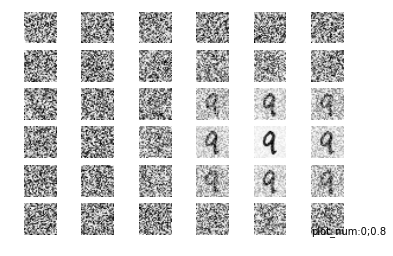

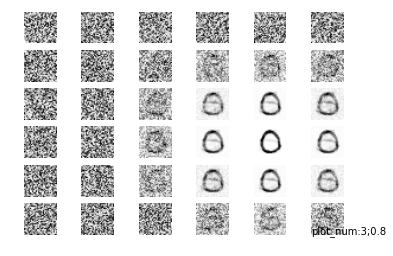

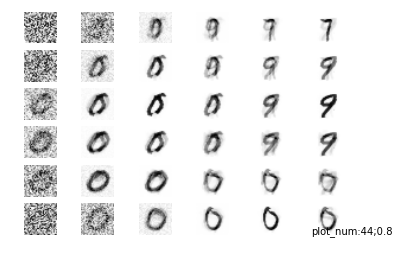

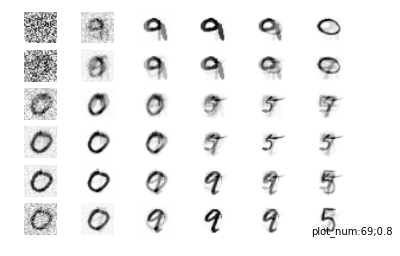

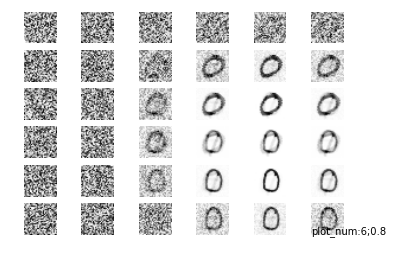

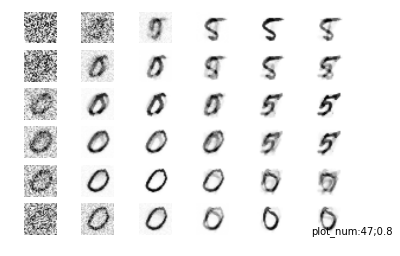

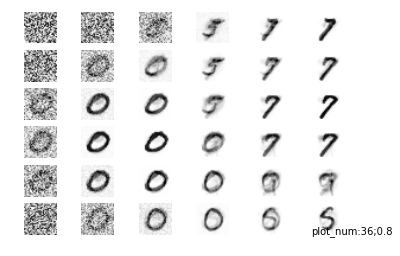

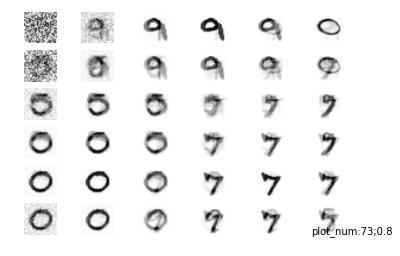

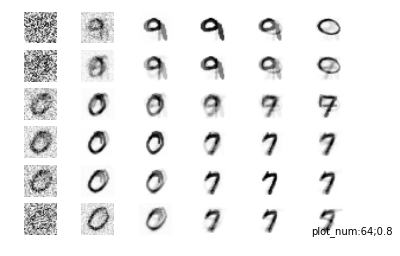

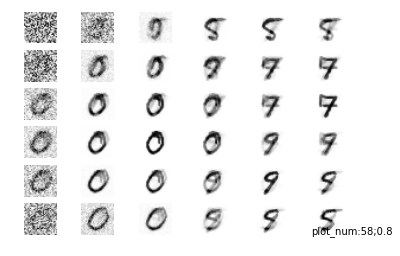

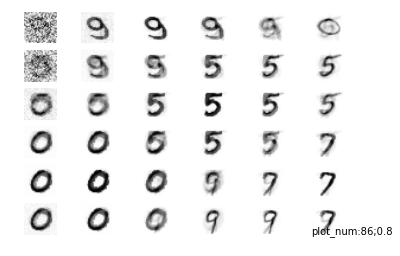

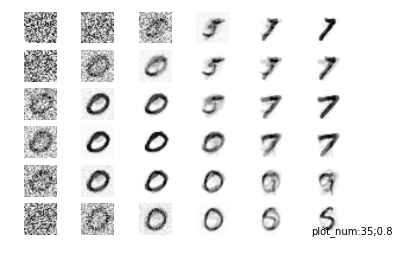

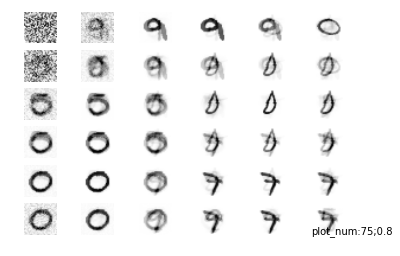

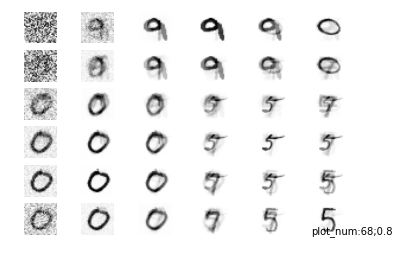

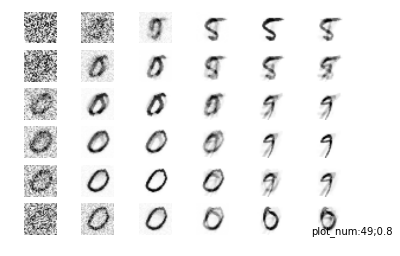

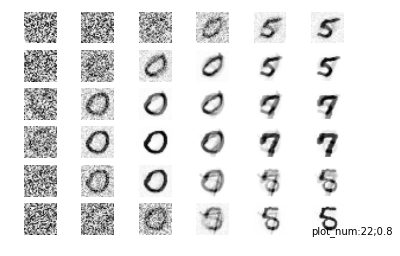

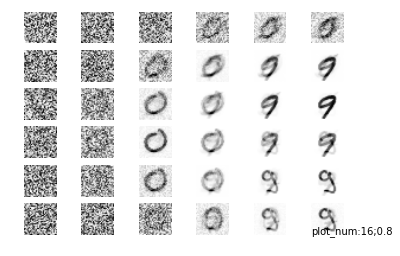

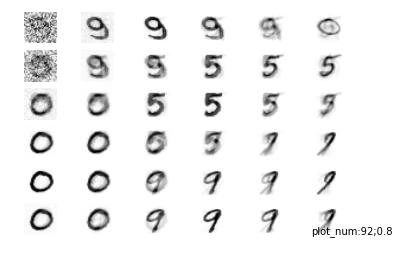

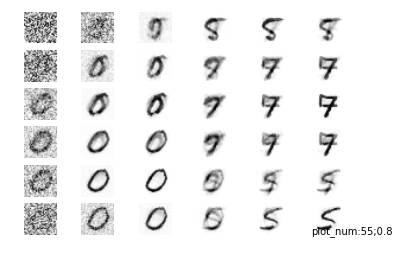

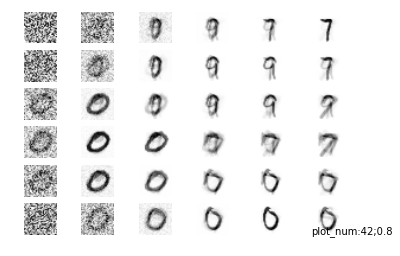

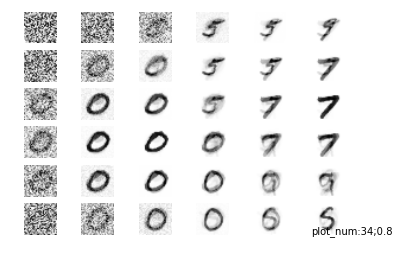

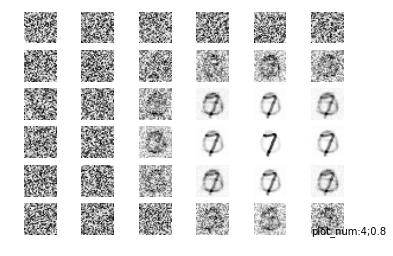

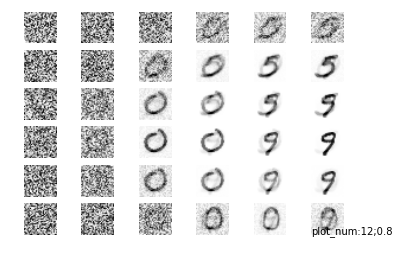

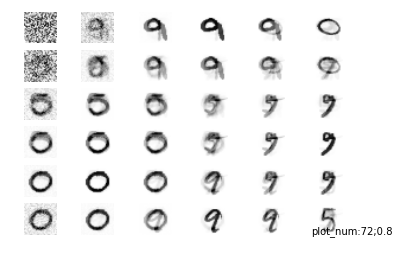

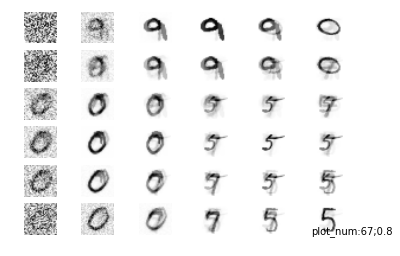

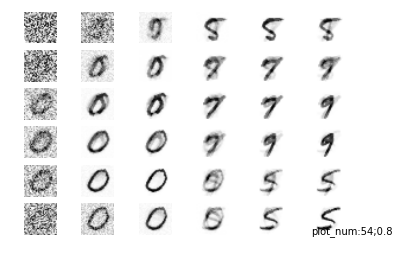

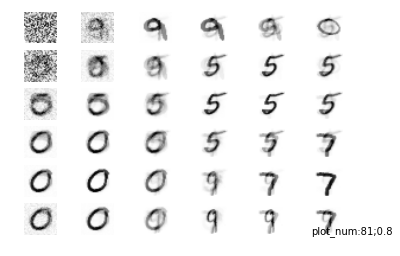

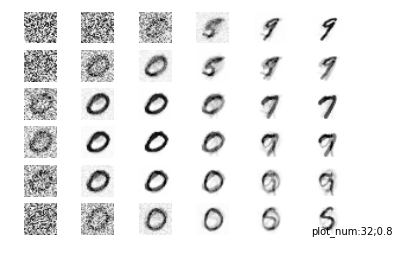

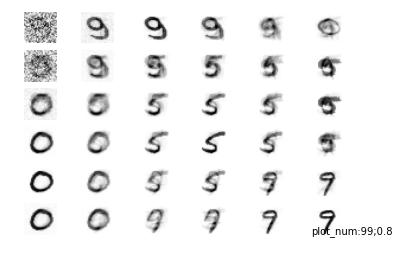

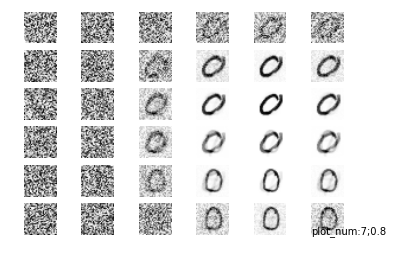

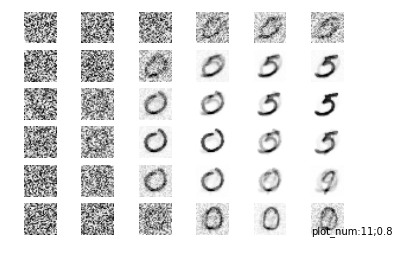

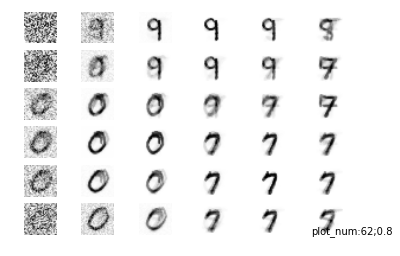

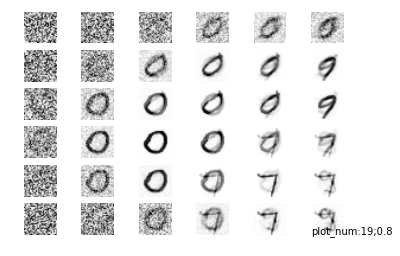

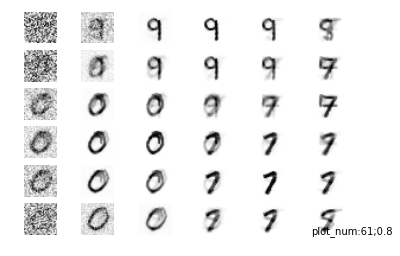

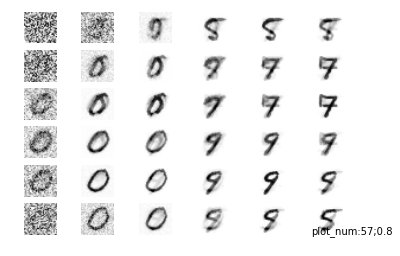

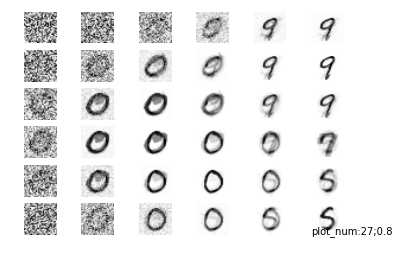

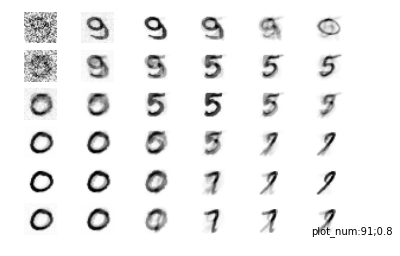

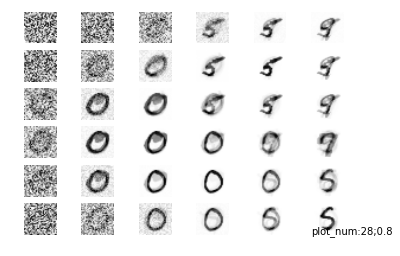

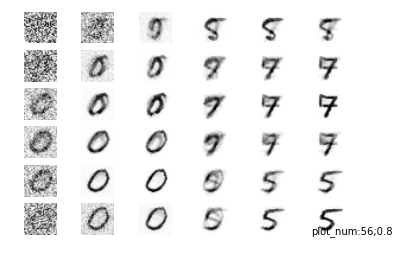

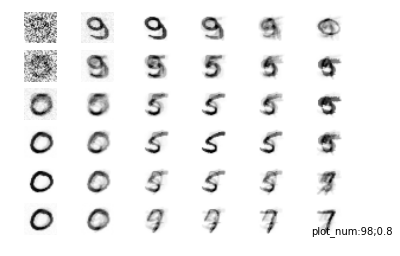

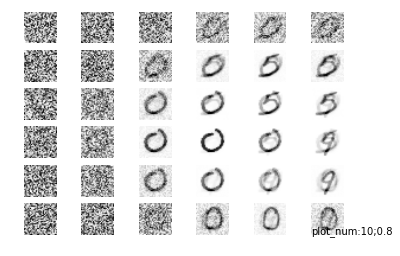

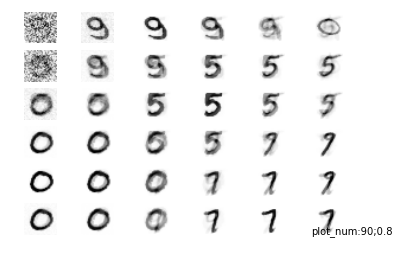

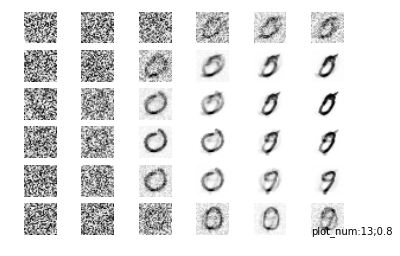

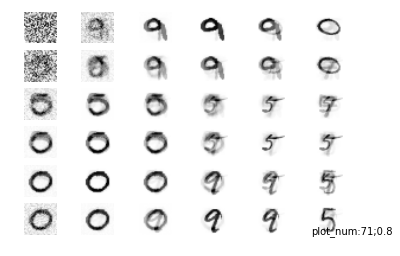

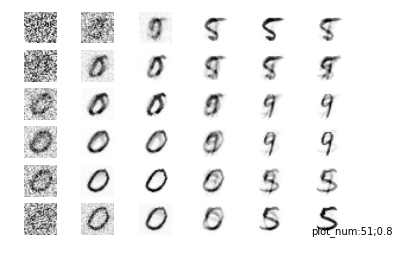

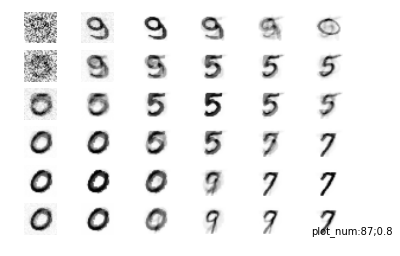

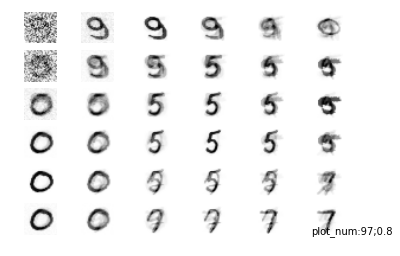

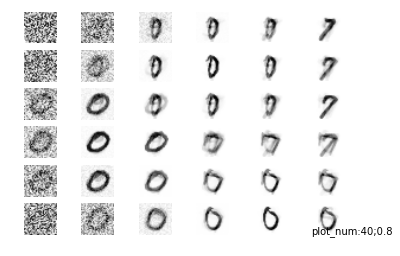

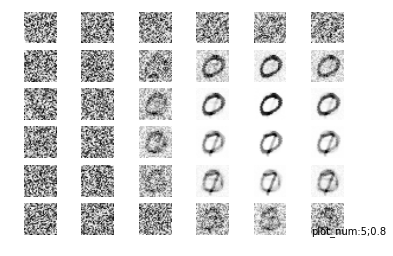

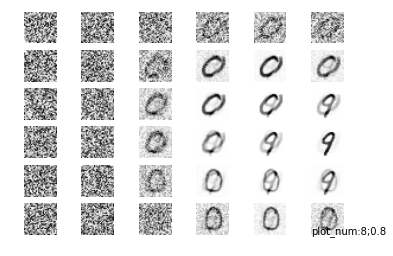

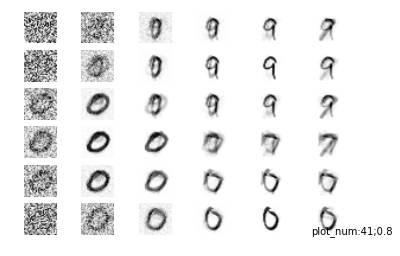

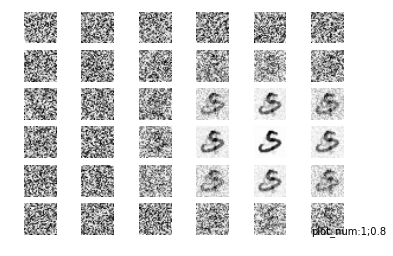

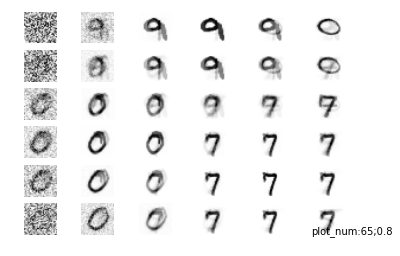

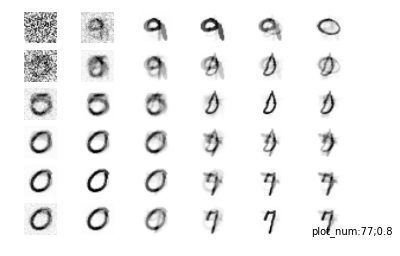

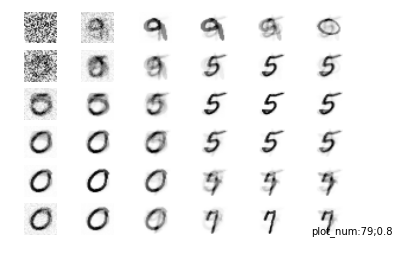

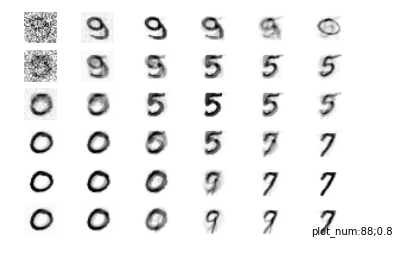

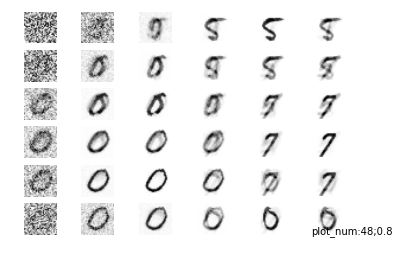

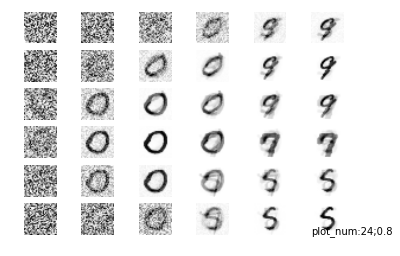

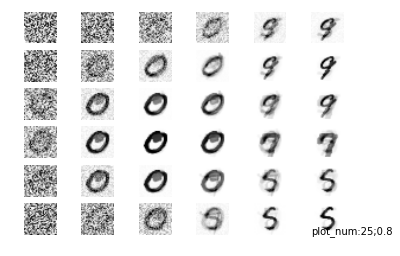

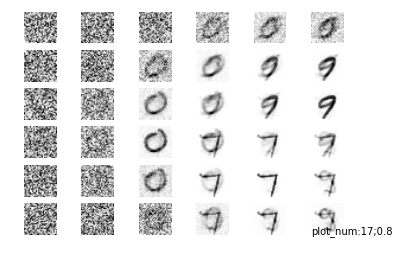

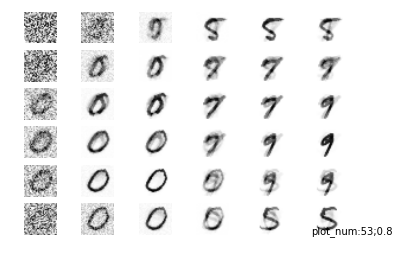

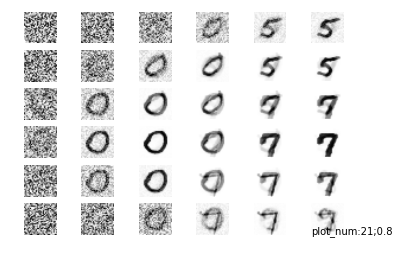

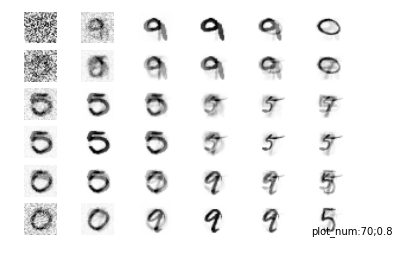

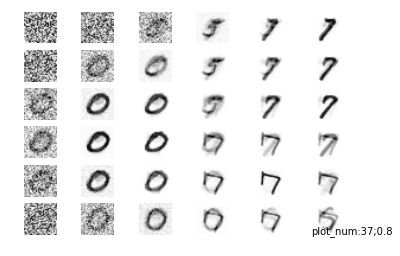

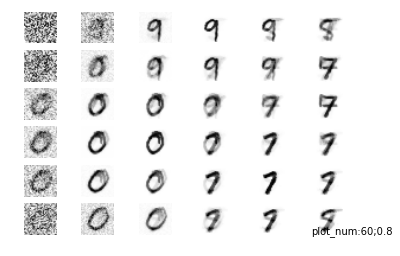

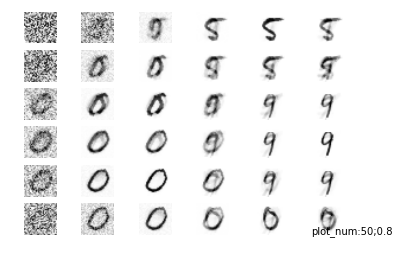

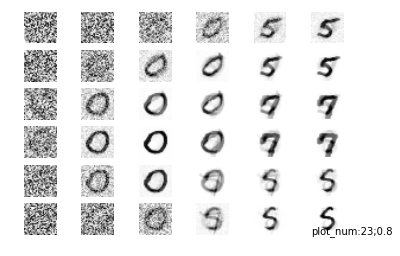

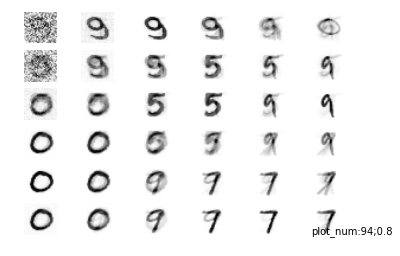

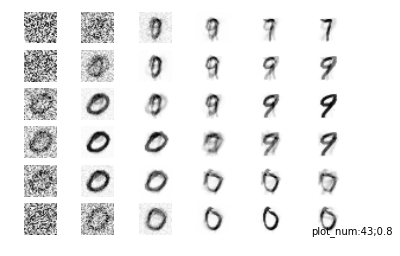

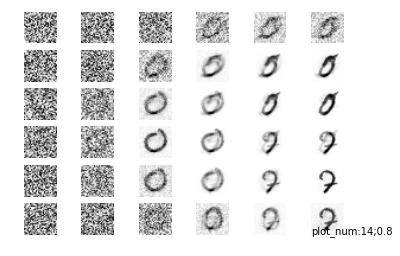

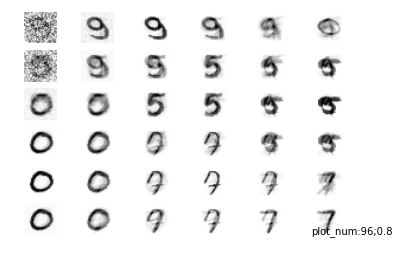

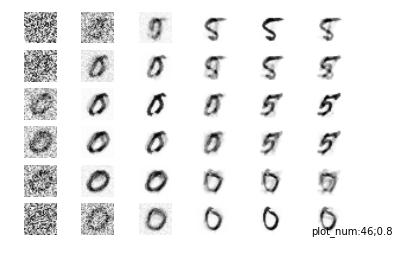

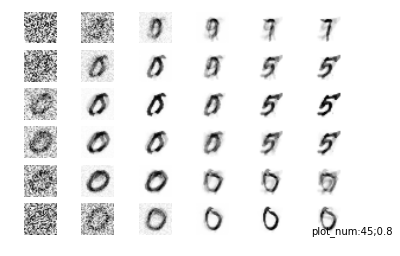

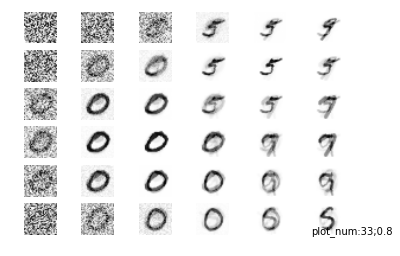

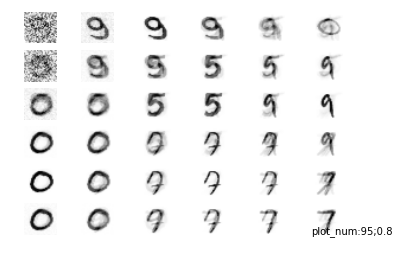

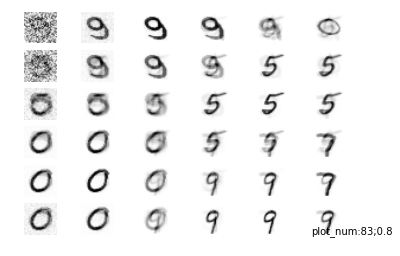

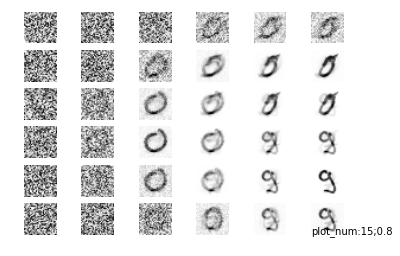

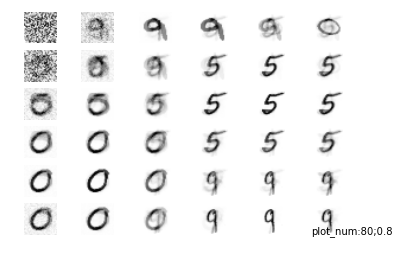

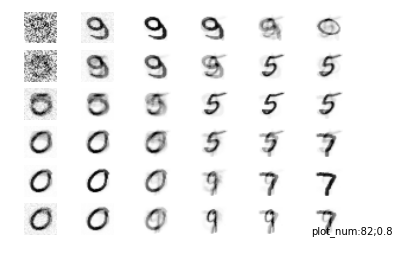

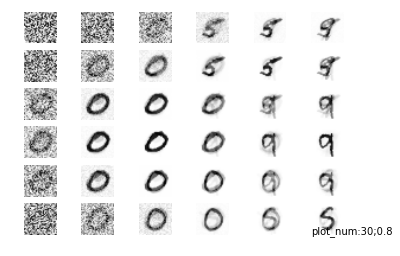

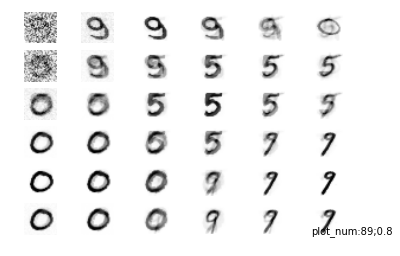

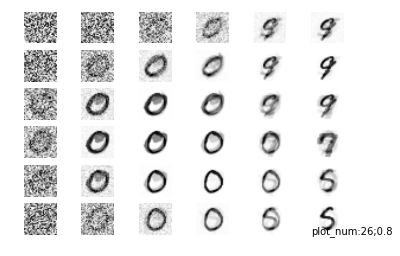

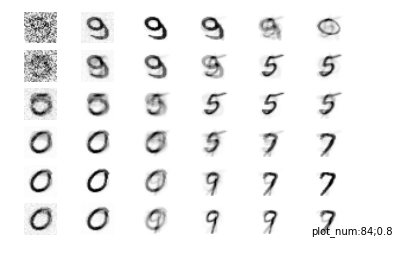

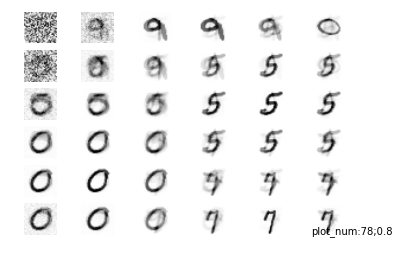

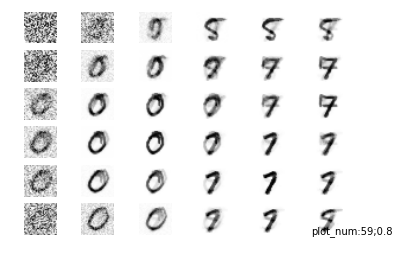

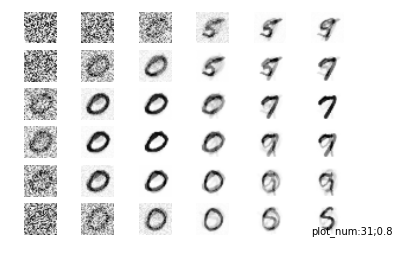

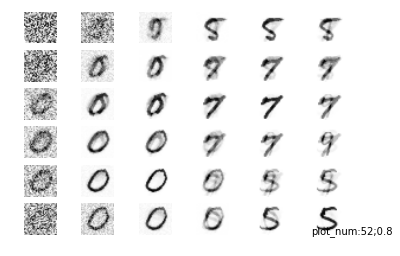

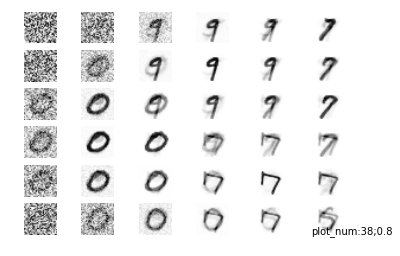

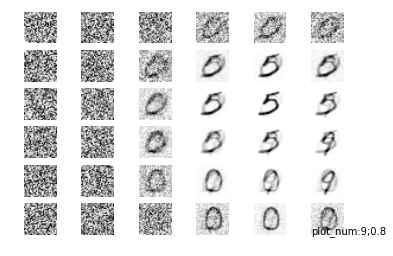

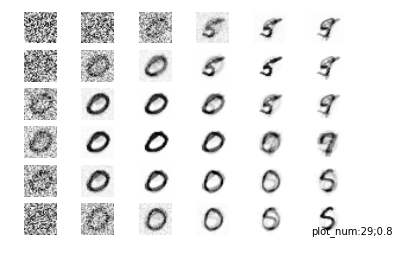

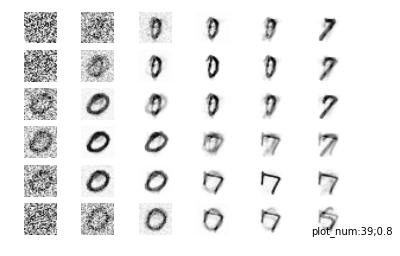

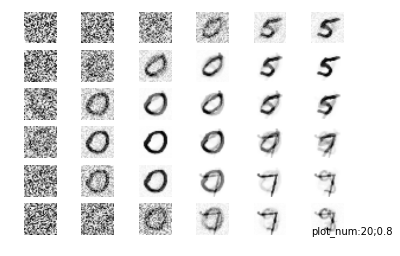

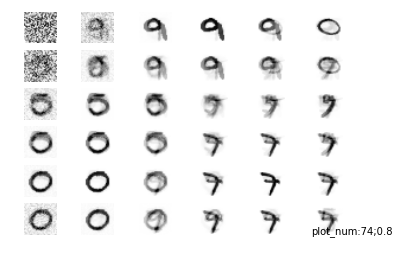

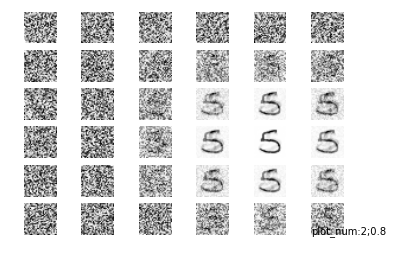

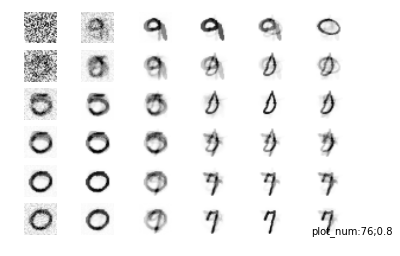

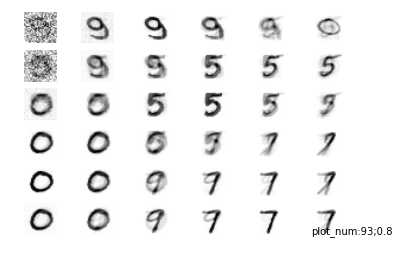

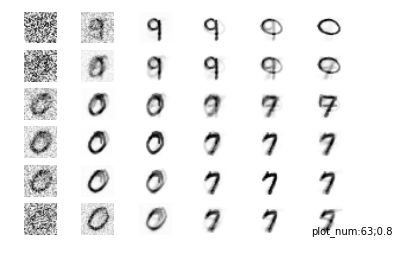

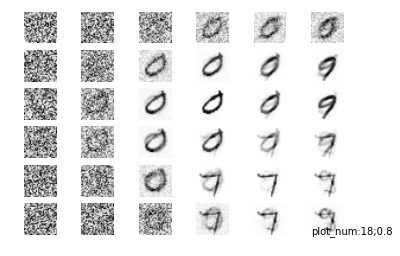

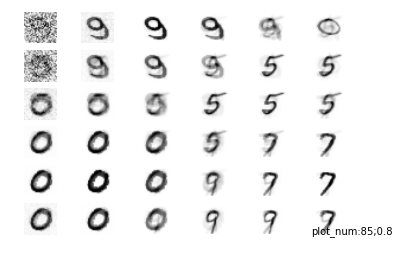

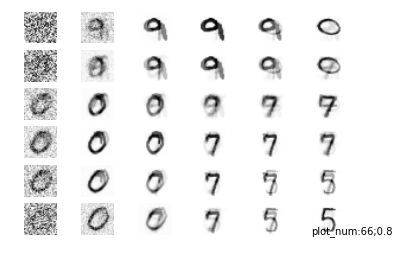

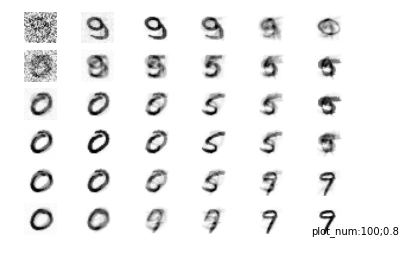

In [3]:
def kohonen(data,labels,ite_num):
    """Example for using create_data, plot_data and som_step.
    """
    plb.close('all')
    
    
    for a in range(0,np.shape(ite_num)[0]):    
        #initialise the centers randomly
        centers = np.random.rand(size_k**2, dim) * data_range
        #build a neighborhood matrix
        neighbor = np.arange(size_k**2).reshape((size_k, size_k))
        #set the random order in which the datapoints should be presented
        i_random = np.arange(tmax) % dy
        np.random.shuffle(i_random)
        plb.figure
        losses = np.zeros((tmax*np.shape(ite_num)[0],36))
        print("Iteration number is",a,". Will iterate",ite_num[a],"time on the data set here.")
        print(np.shape(ite_num))
        for j in range(0,np.shape(ite_num)[0]):
            #np.random.shuffle(i_random)
            eta = 1*ite_num[j]
            for t, i in enumerate(i_random):
                new_centers = som_step(centers, data[i,:],neighbor,eta,sigma)
                losses[i*(j+1),:] = (MSE(centers,new_centers))
                centers = new_centers
                if(t<=100):

    # for visualization, you can use this:
                    plb.figure(i)
                    
                    for i in range(0,size_k**2):
                        plb.subplot(size_k,size_k,i+1)
        
                        plb.imshow(np.reshape(centers[i,:], [28, 28]),cmap='Greys',interpolation='bilinear')
                        plb.axis('off')
                    plb.annotate("plot_num:"+str(t)+";"+str(eta),xy=(0,27))
                    plb.savefig("plots/plot"+"_eta"+str(eta)+"_num"+str(t)+".png")
                    plb.close(i)
    # leave the window open at the end of the loop
        plb.show()
        plb.draw()
               
        return losses,i_random,data

ite_nums = [0.8]
losses,i_random,newdata = kohonen(data,labels,ite_nums)

In [72]:
def check_conv(losses, conv_fact,nbrValues):
    assert(np.shape(losses)[0]>=nbrValues*2)
    part1 = losses[np.shape(losses)[0]-nbrValues:np.shape(losses)[0]]
    part2 = losses[np.shape(losses)[0]-nbrValues*2:np.shape(losses)[0]-nbrValues]
    p1 = sum(part1)/nbrValues
    p2 = sum(part2)/nbrValues
    return p1, p2, p1/p2>conv_fact

def kohonen_conv(data,labels,learning_rate,convergence_factor):
    time_s = time.time()
    """Example for using create_data, plot_data and som_step.
    """
    plb.close('all')
    
    losses = []   
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)
    plb.figure
    run = 1
    c = 0
    while(run):
        c+=1
        time_f = time.time()
        print("Going for a run!")
        print("   Duration so far: ",((time_f-time_s)-(time_f-time_s)%60)/60," min et ",(time_f-time_s)%60," secondes.")
        for t, i in enumerate(i_random):
            centers = som_step(centers, data[i,:],neighbor,learning_rate,sigma)
            loss = reconstruction_error(centers,data)
            losses.append(loss)
            p1, p2, result = check_conv(losses,convergence_factor,49)
             if(result):
                break;
            if(t%100==0 and t>1):
                print("   Checking convergence!")
                print("   p1 is:",p1)
                print("   p2 is:",p2)
                print("   So result is",p1/p2,"<>",convergence_factor)
    time_f = time.time()
    print("Total Duration : ",((time_f-time_s)-(time_f-time_s)%60)/60," min et ",(time_f-time_s)%60," secondes.")
    return losses, c,t

losses2,big_loop,small_loop =kohonen_conv(data,labels,0.2,0.9999)

Going for a run!
   Duration so far:  0.0  min et  0.0009999275207519531  secondes.
   Checking convergence!
   p1 is: 3423788.84091
   p2 is: 3769440.10086
   So result is 0.908301697149 <> 0.99
   Checking convergence!
   p1 is: 3257757.30707
   p2 is: 3316072.59475
   So result is 0.982414351311 <> 0.99
   Checking convergence!
   p1 is: 3228579.41343
   p2 is: 3235746.23275
   So result is 0.997785110818 <> 0.99
Total Duration :  0.0  min et  0.0009999275207519531  secondes.


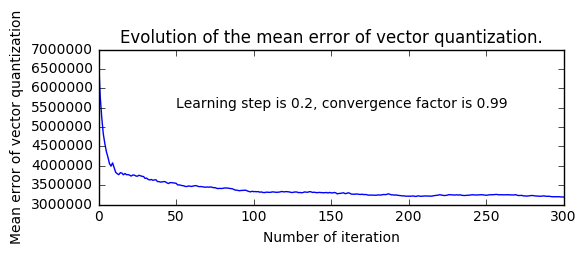

In [99]:
#Visualize error evolution:
def visualize_error(losses_, param):
    learning_rate = param[0]
    conv = param[1]
    plb.figure(figsize=(6,2))   
    plb.title("Evolution of the mean error of vector quantization.")
    plb.annotate(("Learning step is "+str(learning_rate)+", convergence factor is "+str(conv)),xy=(50,5500000))
    plb.ylabel("Mean error of vector quantization")
    plb.xlabel("Number of iteration")
    i_s = np.arange(np.shape(losses_)[0])#np.arange(learning_rates[i])
    plb.plot(i_s,losses_)
    plb.savefig("plots_report/Graph_new_error_evloution_lr"+str(learning_rate)+".jpg")
        
param = [0.2,0.99]
visualize_error(losses2,param)

Ploting result with : 4000 iteration, i.e. 2 times 2000


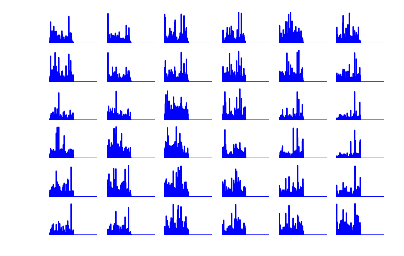

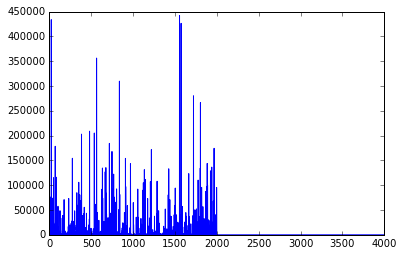

In [88]:
a = 0
print("Ploting result with :",ite_nums[a]*tmax,"iteration, i.e.",ite_nums[a],"times",tmax)
i_s = np.arange(0,tmax*ite_nums[a])
for i in range(0,size_k**2):
    plb.subplot(size_k,size_k,i+1)
    plb.plot(i_s,losses[:,i])
    plb.axis('off')

plb.figure()
plb.plot(i_s,losses[:,i])

In [80]:


print(losses[1985:2010,8])
print(losses[2000,:])

[  2.23410177e+01   4.82702370e+02   9.13795321e+03   3.46389943e-02
   3.32062223e+00   3.80914531e+03   1.37348929e+01   2.87779792e+03
   4.78304129e+00   3.78530923e+01   3.63339018e+00   1.39167624e+01
   5.51086351e+04   4.44736806e+01   3.58903267e-01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
